# Train an AI to play a game of your own with Stable-Baselines3

## Define the game environment

Here we define the game we want the AI to play using the OpenAI Gym class gym.env format. In the example here we set up a Snake game with two walls in the middle.
We further need to define 3 things here:
1. What information does the player have about the state of the game (i.e., observation space)?
2. What possible actions the player can take (i.e., action space)?
3. What is the reward scheme?

In [ ]:
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
%matplotlib inline

class Snake_game(gym.Env):
    """
    Custom Environment for Stable Baseline 3 for the classic Snake 
    """
    metadata = {'render.modes': ['console','rgb_array']}
    #Direction constants
    n_actions = 3 #3 possible steps each turn
    LEFT = 0
    STRAIGHT = 1
    RIGHT = 2
    #Grid label constants
    EMPTY = 0
    SNAKE = 1
    WALL = 2
    FOOD = 3
    #Rewards
    #REWARD_PER_STEP = 0 # reward for every step taken, gets into infinite loops if >0
    #Define Max steps to avoid infinite loops
    REWARD_WALL_HIT = -20 #should be lower than -REWARD_PER_STEP_TOWARDS_FOOD to avoid hitting wall intentionally
    REWARD_PER_STEP_TOWARDS_FOOD = 1 #give reward for moving towards food and penalty for moving away
    REWARD_PER_FOOD = 50 
    MAX_STEPS_AFTER_FOOD = 200 #stop if we go too long without food to avoid infinite loops


    def __init__(self, grid_size=12):
        super(Snake_game, self).__init__()
        #Steps so far
        self.stepnum = 0; self.last_food_step=0
        # Size of the 2D grid (including walls)
        self.grid_size = grid_size
        # Initialize the snake
        self.snake_coordinates = [ (1,1), (2,1) ] #Start in lower left corner
        #Init the grid
        self.grid = np.zeros( (self.grid_size, self.grid_size) ,dtype=np.uint8) + self.EMPTY
        self.grid[0,:] = self.WALL; self.grid[:,0] = self.WALL; #wall at the egdes
        self.grid[int(grid_size/2),3:(grid_size-3)] = self.WALL; #inner wall to make the game harder
        self.grid[4:(grid_size-4),int(grid_size/2-1)] = self.WALL; #inner wall to make the game harder
        #self.grid[int(grid_size/2),2:(grid_size-2)] = self.WALL; #inner wall to make the game harder
        self.grid[self.grid_size-1,:] = self.WALL; self.grid[:,self.grid_size-1] = self.WALL
        for coord in self.snake_coordinates:
            self.grid[ coord ] = self.SNAKE  #put snake on grid
        self.grid[3,3] = self.FOOD  #Start in upper right corner
        #Init distance to food
        self.head_dist_to_food = self.grid_distance(self.snake_coordinates[-1],np.argwhere(self.grid==self.FOOD)[0] )
        #Store init values
        self.init_grid = self.grid.copy()
        self.init_snake_coordinates = self.snake_coordinates.copy()
        
        # The action space
        self.action_space = spaces.Discrete(self.n_actions)
        # The observation space, "position" is the coordinates of the head; "direction" is which way the sanke is heading, "grid" contains the full grid info
        self.observation_space = gym.spaces.Dict(
            spaces={
                "position": gym.spaces.Box(low=0, high=(self.grid_size-1), shape=(2,), dtype=np.int32),
                "direction": gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.int32),
                "grid": gym.spaces.Box(low = 0, high = 3, shape = (self.grid_size, self.grid_size), dtype=np.uint8),
            })
    
    def grid_distance(self,pos1,pos2):
        return np.linalg.norm(np.array(pos1,dtype=np.float32)-np.array(pos2,dtype=np.float32))

    def reset(self):
        # Reset to initial positions
        self.stepnum = 0; self.last_food_step=0
        self.grid = self.init_grid.copy()
        self.snake_coordinates = self.init_snake_coordinates.copy()
        #Init distance to food
        self.head_dist_to_food = self.grid_distance(self.snake_coordinates[-1],np.argwhere(self.grid==self.FOOD)[0] )
        return self._get_obs()    
             
    def _get_obs(self):
            direction = np.array(self.snake_coordinates[-1]) - np.array(self.snake_coordinates[-2])
            #return observation in the format of self.observation_space
            return {"position": np.array(self.snake_coordinates[-1],dtype=np.int32),
                    "direction" : direction.astype(np.int32),
                    "grid": self.grid}                  
            
    def step(self, action):
        #Get direction for snake
        direction = np.array(self.snake_coordinates[-1]) - np.array(self.snake_coordinates[-2])
        if action == self.STRAIGHT:
            step = direction #step in the firection the snake faces
        elif action == self.RIGHT:
            step = np.array( [direction[1], -direction[0]] )  #turn right
        elif action == self.LEFT:
            step = np.array( [-direction[1], direction[0]] )   #turn left
        else:
            raise ValueError("Action=%d is not part of the action space"%(action))
        #New head coordinate
        new_coord = (np.array(self.snake_coordinates[-1]) + step).astype(np.int32)
        #grow snake     
        self.snake_coordinates.append( (new_coord[0],new_coord[1]) ) #convert to tuple so we can use it to index

        
        #Check what is at the new position
        new_pos = self.snake_coordinates[-1]
        new_pos_type = self.grid[new_pos]
        self.grid[new_pos] = self.SNAKE #this position is now occupied by the snake
        done = False; reward = 0 #by default the game goes on and no reward   
        if new_pos_type == self.FOOD:
            reward += self.REWARD_PER_FOOD
            self.last_food_step = self.stepnum
            #Put down a new food item
            empty_tiles = np.argwhere(self.grid==self.EMPTY)
            if len(empty_tiles):
                new_food_pos=empty_tiles[np.random.randint(0,len(empty_tiles))]
                self.grid[new_food_pos[0],new_food_pos[1]] = self.FOOD
            else:
                done = True #no more tiles to put the food to
        else:
            #If no food was eaten we remove the end of the snake (i.e., moving not growing)
            self.grid[ self.snake_coordinates[0] ] = self.EMPTY
            self.snake_coordinates = self.snake_coordinates[1:]
            if  (new_pos_type == self.WALL) or (new_pos_type == self.SNAKE):
                done = True #stop if we hit the wall or the snake
                reward += self.REWARD_WALL_HIT #penalty for hitting walls/tail
#             else:
#                 reward += self.REWARD_PER_STEP
                
        #Update distance to food and reward if closer
        head_dist_to_food_prev = self.head_dist_to_food
        self.head_dist_to_food = self.grid_distance( self.snake_coordinates[-1],np.argwhere(self.grid==self.FOOD)[0] )
        if head_dist_to_food_prev > self.head_dist_to_food:
            reward += self.REWARD_PER_STEP_TOWARDS_FOOD #reward for getting closer to food
        elif head_dist_to_food_prev < self.head_dist_to_food:
            reward -= self.REWARD_PER_STEP_TOWARDS_FOOD #penalty for getting further
        
        #Stop if we played too long without getting food
        if ( (self.stepnum - self.last_food_step) > self.MAX_STEPS_AFTER_FOOD ): 
            done = True    
        self.stepnum += 1

        return  self._get_obs(), reward, done, {}

    def render(self, mode='rgb_array'):
        if mode == 'console':
            print(self.grid)
        elif mode == 'rgb_array':
            return self.snake_plot()
        else:
            raise NotImplementedError()

    def close(self):
        pass
    
    def snake_plot(self, plot_inline=False):
        wall_ind = (self.grid==self.WALL)
        snake_ind = (self.grid==self.SNAKE)
        food_ind = (self.grid==self.FOOD)
        #Create color array for plot, default white color
        Color_array=np.zeros((self.grid_size,self.grid_size,3),dtype=np.uint8)+255 #default white
        Color_array[wall_ind,:]= np.array([0,0,0]) #black walls
        Color_array[snake_ind,:]= np.array([0,0,255]) #bluish snake
        Color_array[food_ind,:]= np.array([0,255,0]) #green food  
        #plot
        if plot_inline:
            fig=plt.figure()
            plt.axis('off')
            plt.imshow(Color_array, interpolation='nearest')
            plt.show()
        return Color_array
    
    

## Testing the environment
It is quite easy to make mistakes in defining the environment so it is good practice to not only use the built-in environment checker of stable-baselines but also to manually play it to see if things work.

In [ ]:
#Built in environment check
from stable_baselines3.common.env_checker import check_env
env = Snake_game()
# If the environment doesn't follow the interface, an error will be thrown
check_env(env, warn=True)

In [ ]:
# #Manual testing
# import matplotlib.animation as animation
# from time import sleep

# env = Snake_game()
# env.reset()

# #Image for initial state
# fig, ax = plt.subplots(figsize=(6,6))
# plt.imshow(env.render(mode='rgb_array'))
# plt.axis('off')
# plt.savefig("snake_init.png",dpi=150)

# #Framework to save animgif
# frames = []
# fps=24

# n_steps = 20
# for step in range(n_steps):
#     print("Step {}".format(step + 1))
#     obs, reward, done, info = env.step(0)
#     print('position=', obs['position'], 'direction=', obs['direction'])
#     print('reward=', reward, 'done=', done)
#     frames.append([ax.imshow(env.render(mode='rgb_array'), animated=True)])
#     if done:
#         print("Game over!", "reward=", reward)
#         break

        
# fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None) #to remove white bounding box        
# anim = animation.ArtistAnimation(fig, frames, interval=int(1000/fps), blit=True,repeat_delay=1000)
# anim.save("snake_test.gif",dpi=150)

## Monitoring
We should set up some monitoring for the training using built-in function of stable-baselines (for more advanced version see TensorBoard) and store the parameters of the best performing model

In [31]:
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
import os
#Logging
log_dir = "log"
os.makedirs(log_dir, exist_ok=True)

# Instantiate the env
env = Snake_game()
# wrap it
env = Monitor(env, log_dir)


#Callback, this built-in function will periodically evaluate the model and save the best version
eval_callback = EvalCallback(env, best_model_save_path='./log/',
                             log_path='./log/', eval_freq=5000,
                             deterministic=False, render=False)

## Training
We are training the algorithm with moderate stepnumbers and manually adjust the parameters based on its perfomrance. Since we are always saving the best model we can experiment with different hyperparameters without worrying about messing up the model.

In [ ]:
import time
from stable_baselines3 import PPO

#Train the agent
max_total_step_num = 1e6

def learning_rate_schedule(progress_remaining):
    start_rate = 0.0001 #0.0003
    #Can do more complicated ones like below
    #stepnum = max_total_step_num*(1-progress_remaining)
    #return 0.003 * np.piecewise(stepnum, [stepnum>=0, stepnum>4e4, stepnum>2e5, stepnum>3e5], [1.0,0.5,0.25,0.125 ])
    return start_rate * progress_remaining #linearly decreasing

PPO_model_args = {
    "learning_rate": learning_rate_schedule, #decreasing learning rate #0.0003 #can be set to constant
    "gamma": 0.99, #0.99, discount factor for futurer rewards, between 0 (only immediate reward matters) and 1 (future reward equivalent to immediate), 
    "verbose": 0, #change to 1 to get more info on training steps
    #"seed": 137, #fixing the random seed
    "ent_coef": 0.0, #0, entropy coefficient, to encourage exploration
    "clip_range": 0.2 #0.2, very roughly: probability of an action can not change by more than a factor 1+clip_range
}
starttime = time.time()
model = PPO('MultiInputPolicy', env,**PPO_model_args)
#Load previous best model parameters, we start from that
if os.path.exists("log/best_model.zip"):
    model.set_parameters("log/best_model.zip")
model.learn(max_total_step_num,callback=eval_callback)
dt = time.time()-starttime
print("Calculation took %g hr %g min %g s"%(dt//3600, (dt//60)%60, dt%60) )

### Check performance
Basic plotting with built-in functions

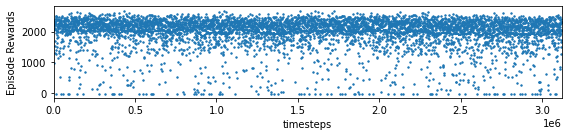

In [38]:
from stable_baselines3.common import results_plotter
# Helper from the library, a bit hard to read but immediately useable
results_plotter.plot_results(["log"], 1e7, results_plotter.X_TIMESTEPS,'')

Custom plotting

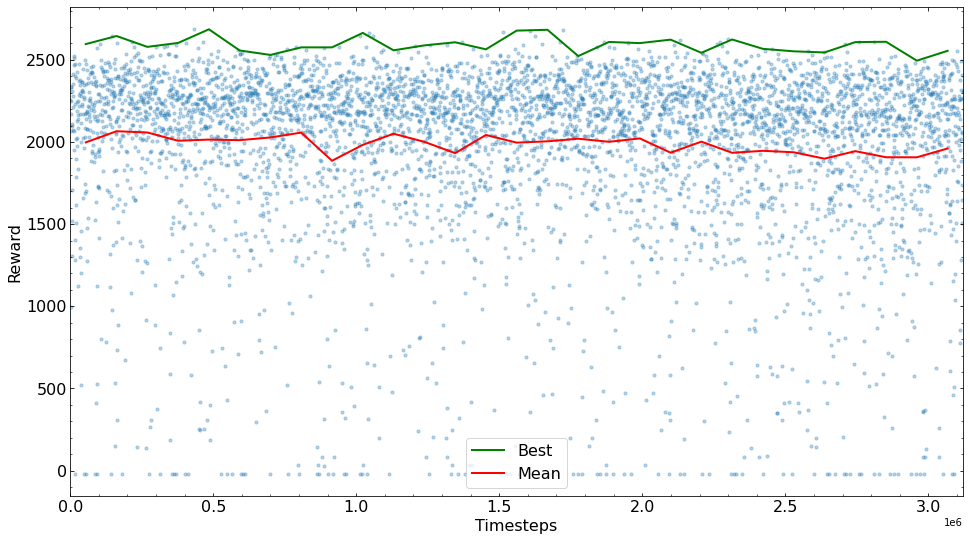

In [39]:
#A bit more advanced plotting
def adjust_font(lgnd=None, lgnd_handle_size=64, fig=None, ax_fontsize=16, labelfontsize=16,do_ticks=True ):
    if not (lgnd is None):
        for handle in lgnd.legendHandles:
            handle.set_sizes([lgnd_handle_size])
    if not (fig is None):
        ax_list = fig.axes
        for ax1 in ax_list:
            ax1.tick_params(axis='both', labelsize=ax_fontsize)
            ax1.set_xlabel(ax1.get_xlabel(),fontsize=labelfontsize)
            ax1.set_ylabel(ax1.get_ylabel(),fontsize=labelfontsize)
            if do_ticks:
                ax1.minorticks_on()
                ax1.tick_params(axis='both',which='both', direction='in',top=True,right=True)

max_possible_reward =env.REWARD_PER_FOOD * np.sum(env.init_grid==env.EMPTY)

from stable_baselines3.common.monitor import load_results
train_step_log = load_results("log")
x = np.array(train_step_log["l"].cumsum())
y = np.array(train_step_log["r"])

plot_from_step = 0
y = y[x>=plot_from_step]; x = x[x>=plot_from_step]

fig1, ax1 = plt.subplots(1,1)
fig1.set_size_inches(16, 9)

max_points_to_plot = 20000
index_to_plot = np.linspace(0,len(train_step_log)-1,np.clip(len(train_step_log),None,max_points_to_plot)).astype(int)
plt.scatter(x[index_to_plot],y[index_to_plot], alpha=0.3, s=10)

x_edges = np.linspace(x.min(),x.max(),num=30)
xbins = (x_edges[:-1]+x_edges[1:])/2.0
binnumber = np.digitize(x, x_edges) - 1
reward50=np.zeros_like(xbins); reward75=np.zeros_like(xbins); reward25=np.zeros_like(xbins); reward_mean=np.zeros_like(xbins)
reward_max = np.zeros_like(xbins)
for i in range(len(xbins)):
    ind=(binnumber==i)
    if (np.sum(ind)>0):
        reward_mean[i] = np.mean(y[ind])
        reward50[i]=np.median(y[ind])
        reward25[i]=np.percentile(y[ind],25)
        reward75[i]=np.percentile(y[ind],75)
        reward_max[i] = np.max(y[ind])

plt.plot(xbins,reward_max,c='g',lw=2, label="Best")        
plt.plot(xbins,reward_mean,c='r',lw=2, label="Mean")
#plt.plot(xbins,reward50,c='k',lw=2, label="Median")
#plt.plot(xbins,reward75,'--',c='k',lw=2, label="Interquartile range")
#plt.plot(xbins,reward25,'--',c='k',lw=2)
if plt.ylim()[1]>0.8*max_possible_reward:
    plt.axhline(y=max_possible_reward, c='r', linestyle=':')
plt.xlim([0,x.max()])
plt.xlabel('Timesteps'); plt.ylabel('Reward')
plt.legend(fontsize=16)
adjust_font(fig=fig1)
plt.savefig("snake_rewards.png",dpi=150, bbox_inches="tight")
plt.show()

## Demonstration
Once we have trained a model we can make a movie of it playing the game (which can also be used to see what behaviors it might have problems with that we can correct for in e.g., the reward scheme)

In [44]:
#Load back the best model
model.set_parameters("log/best_model.zip")
from stable_baselines3.common.evaluation import evaluate_policy
# Evaluate the trained model
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print("Best model's reward: %3.3g +/- %3.3g"%(mean_reward,std_reward))

Best model's reward: 2.13e+03 +/- 305


Step 1 Action:  0 Tot. Reward: 1
Step 2 Action:  1 Tot. Reward: 2
Step 3 Action:  2 Tot. Reward: 51
Step 4 Action:  2 Tot. Reward: 50
Step 5 Action:  0 Tot. Reward: 49
Step 6 Action:  1 Tot. Reward: 48
Step 7 Action:  1 Tot. Reward: 47
Step 8 Action:  1 Tot. Reward: 46
Step 9 Action:  1 Tot. Reward: 45
Step 10 Action:  0 Tot. Reward: 46
Step 11 Action:  1 Tot. Reward: 47
Step 12 Action:  1 Tot. Reward: 48
Step 13 Action:  1 Tot. Reward: 47
Step 14 Action:  1 Tot. Reward: 46
Step 15 Action:  1 Tot. Reward: 45
Step 16 Action:  1 Tot. Reward: 44
Step 17 Action:  0 Tot. Reward: 45
Step 18 Action:  1 Tot. Reward: 46
Step 19 Action:  1 Tot. Reward: 47
Step 20 Action:  1 Tot. Reward: 48
Step 21 Action:  0 Tot. Reward: 49
Step 22 Action:  2 Tot. Reward: 50
Step 23 Action:  0 Tot. Reward: 51
Step 24 Action:  2 Tot. Reward: 52
Step 25 Action:  0 Tot. Reward: 53
Step 26 Action:  1 Tot. Reward: 102
Step 27 Action:  1 Tot. Reward: 101
Step 28 Action:  1 Tot. Reward: 100
Step 29 Action:  0 Tot. Rewa

Step 260 Action:  1 Tot. Reward: 992
Step 261 Action:  1 Tot. Reward: 993
Step 262 Action:  0 Tot. Reward: 992
Step 263 Action:  1 Tot. Reward: 991
Step 264 Action:  1 Tot. Reward: 990
Step 265 Action:  0 Tot. Reward: 989
Step 266 Action:  1 Tot. Reward: 988
Step 267 Action:  2 Tot. Reward: 987
Step 268 Action:  1 Tot. Reward: 986
Step 269 Action:  1 Tot. Reward: 985
Step 270 Action:  1 Tot. Reward: 984
Step 271 Action:  0 Tot. Reward: 983
Step 272 Action:  1 Tot. Reward: 982
Step 273 Action:  1 Tot. Reward: 981
Step 274 Action:  1 Tot. Reward: 980
Step 275 Action:  0 Tot. Reward: 981
Step 276 Action:  2 Tot. Reward: 980
Step 277 Action:  0 Tot. Reward: 981
Step 278 Action:  1 Tot. Reward: 982
Step 279 Action:  1 Tot. Reward: 983
Step 280 Action:  1 Tot. Reward: 984
Step 281 Action:  1 Tot. Reward: 985
Step 282 Action:  1 Tot. Reward: 986
Step 283 Action:  1 Tot. Reward: 987
Step 284 Action:  0 Tot. Reward: 988
Step 285 Action:  1 Tot. Reward: 989
Step 286 Action:  1 Tot. Reward: 990
S

Step 542 Action:  0 Tot. Reward: 1574
Step 543 Action:  1 Tot. Reward: 1623
Step 544 Action:  2 Tot. Reward: 1624
Step 545 Action:  1 Tot. Reward: 1623
Step 546 Action:  0 Tot. Reward: 1622
Step 547 Action:  1 Tot. Reward: 1621
Step 548 Action:  1 Tot. Reward: 1620
Step 549 Action:  1 Tot. Reward: 1619
Step 550 Action:  0 Tot. Reward: 1620
Step 551 Action:  2 Tot. Reward: 1619
Step 552 Action:  0 Tot. Reward: 1618
Step 553 Action:  0 Tot. Reward: 1619
Step 554 Action:  2 Tot. Reward: 1618
Step 555 Action:  2 Tot. Reward: 1617
Step 556 Action:  0 Tot. Reward: 1616
Step 557 Action:  0 Tot. Reward: 1617
Step 558 Action:  2 Tot. Reward: 1616
Step 559 Action:  0 Tot. Reward: 1617
Step 560 Action:  2 Tot. Reward: 1616
Step 561 Action:  1 Tot. Reward: 1615
Step 562 Action:  1 Tot. Reward: 1614
Step 563 Action:  0 Tot. Reward: 1615
Step 564 Action:  2 Tot. Reward: 1614
Step 565 Action:  0 Tot. Reward: 1615
Step 566 Action:  1 Tot. Reward: 1616
Step 567 Action:  1 Tot. Reward: 1617
Step 568 Act

Step 783 Action:  0 Tot. Reward: 1959
Step 784 Action:  0 Tot. Reward: 1960
Step 785 Action:  2 Tot. Reward: 1961
Step 786 Action:  2 Tot. Reward: 1960
Step 787 Action:  0 Tot. Reward: 1959
Step 788 Action:  0 Tot. Reward: 1960
Step 789 Action:  2 Tot. Reward: 1959
Step 790 Action:  1 Tot. Reward: 1958
Step 791 Action:  0 Tot. Reward: 1959
Step 792 Action:  0 Tot. Reward: 1960
Step 793 Action:  2 Tot. Reward: 1961
Step 794 Action:  2 Tot. Reward: 1960
Step 795 Action:  0 Tot. Reward: 1961
Step 796 Action:  0 Tot. Reward: 1962
Step 797 Action:  2 Tot. Reward: 1963
Step 798 Action:  2 Tot. Reward: 1962
Step 799 Action:  0 Tot. Reward: 1963
Step 800 Action:  0 Tot. Reward: 1964
Step 801 Action:  2 Tot. Reward: 1963
Step 802 Action:  0 Tot. Reward: 1964
Step 803 Action:  0 Tot. Reward: 1965
Step 804 Action:  2 Tot. Reward: 2014
Step 805 Action:  2 Tot. Reward: 2013
Step 806 Action:  0 Tot. Reward: 2014
Step 807 Action:  2 Tot. Reward: 2013
Step 808 Action:  0 Tot. Reward: 2014
Step 809 Act

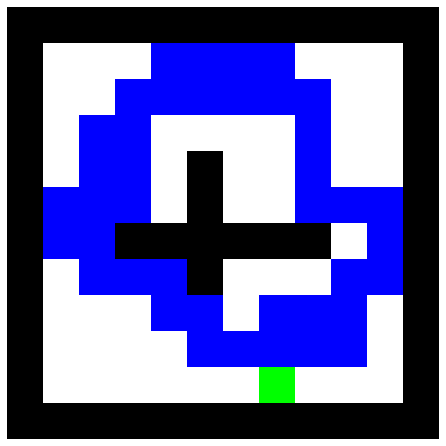

In [43]:
# Test the trained agent and save animation
obs = env.reset()
#Framework to save animgif
fig, ax = plt.subplots(figsize=(6,6))
plt.axis('off')
frames = []
fps=18

n_steps = 1000
tot_reward = 0
for step in range(n_steps):
    action, _ = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    tot_reward += reward
    print("Step {}".format(step + 1),"Action: ", action, 'Tot. Reward: %g'%(tot_reward))
    #print('position=', obs['position'], 'direction=', obs['direction'])
    #env.render(mode='console')
    frames.append([ax.imshow(env.render(mode='rgb_array'), animated=True)])
    if done:
        print("Game over!", "tot. reward=", tot_reward)
        break
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None) #to remove white bounding box 
anim = animation.ArtistAnimation(fig, frames, interval=int(1000/fps), blit=True,repeat_delay=1000)
anim.save("snake_best.gif",dpi=150)